In [1]:
import copy

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
desktop = 'C:/Users/dhers/Desktop'
STORM_folder = os.path.join(desktop, 'STORM/models')

colabels_file = os.path.join(STORM_folder, 'colabeled_data.csv')
data = pd.read_csv(colabels_file)

bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body', 'tail_1', 'tail_2', 'tail_3']
objects = ['obj']
y_col = 'Myself'

In [3]:
def recenter(df, point, bodyparts):
    # Create a copy of the original dataframe
    df_copy = df.copy()
    bodypart_columns = []
    
    for bodypart in bodyparts:
        # Subtract point_x from columns ending in _x
        x_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_x')]
        df_copy[x_cols] = df_copy[x_cols].apply(lambda col: col - df_copy[f'{point}_x'])
        
        # Subtract point_y from columns ending in _y
        y_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_y')]
        df_copy[y_cols] = df_copy[y_cols].apply(lambda col: col - df_copy[f'{point}_y'])
        
        # Collect bodypart columns
        bodypart_columns.extend(x_cols)
        bodypart_columns.extend(y_cols)
        
    return df_copy[bodypart_columns]

In [4]:
x_dfs=[]
y_dfs=[]
for obj in objects:
    x_dfs.append(recenter(data, obj, bodyparts))
    y_dfs.append(data[f'{y_col}'])
X = pd.concat(x_dfs, ignore_index=True)
y = pd.concat(y_dfs, ignore_index=True)

In [5]:
# Binary encoding of labels
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [6]:
# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [7]:
# Define a model
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(17, 60)
        self.relu = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [8]:
# See model size
model = Wide()
print(sum([x.reshape(-1).shape[0] for x in model.parameters()]))  # 11161

1141


In [15]:
# Helper function to train models
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 10   # number of epochs to run
    batch_size = 64  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item()}')
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [16]:
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [17]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores.append(acc)

Epoch [1/10], Loss: 1.4322469234466553
Epoch [1/10], Loss: 1.4661179780960083
Epoch [1/10], Loss: 1.8170404434204102
Epoch [1/10], Loss: 1.5080240964889526
Epoch [1/10], Loss: 1.3551404476165771
Epoch [1/10], Loss: 1.2951183319091797
Epoch [1/10], Loss: 1.467118263244629
Epoch [1/10], Loss: 1.0720804929733276
Epoch [1/10], Loss: 1.3086735010147095
Epoch [1/10], Loss: 1.2224154472351074
Epoch [1/10], Loss: 1.0586330890655518
Epoch [1/10], Loss: 1.258209466934204
Epoch [1/10], Loss: 1.1105554103851318
Epoch [1/10], Loss: 1.2629625797271729
Epoch [1/10], Loss: 1.4336479902267456
Epoch [1/10], Loss: 1.3843392133712769
Epoch [1/10], Loss: 1.139971375465393
Epoch [1/10], Loss: 1.049377679824829
Epoch [1/10], Loss: 1.5413529872894287
Epoch [1/10], Loss: 1.075842261314392
Epoch [1/10], Loss: 0.868293046951294
Epoch [1/10], Loss: 1.3792215585708618
Epoch [1/10], Loss: 1.0498226881027222
Epoch [1/10], Loss: 0.956010639667511
Epoch [1/10], Loss: 0.9336560368537903
Epoch [1/10], Loss: 1.2096382379

In [18]:
# evaluate the model
model_acc = np.mean(cv_scores)
model_std = np.std(cv_scores)

print("Pytorch Model: %.2f%% (+/- %.2f%%)" % (model_acc*100, model_std*100))

Pytorch Model: 97.65% (+/- 0.14%)


In [19]:
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

Epoch [1/10], Loss: 0.055788710713386536
Epoch [1/10], Loss: 0.044140007346868515
Epoch [1/10], Loss: 0.038452960550785065
Epoch [1/10], Loss: 0.08497841656208038
Epoch [1/10], Loss: 0.046014606952667236
Epoch [1/10], Loss: 0.03384077921509743
Epoch [1/10], Loss: 0.06165390461683273
Epoch [1/10], Loss: 0.007190901320427656
Epoch [1/10], Loss: 0.030888736248016357
Epoch [1/10], Loss: 0.05011187121272087
Epoch [1/10], Loss: 0.06466730684041977
Epoch [1/10], Loss: 0.04728173464536667
Epoch [1/10], Loss: 0.06241301819682121
Epoch [1/10], Loss: 0.023458147421479225
Epoch [1/10], Loss: 0.032377541065216064
Epoch [1/10], Loss: 0.021777916699647903
Epoch [1/10], Loss: 0.013548965565860271
Epoch [1/10], Loss: 0.09229256957769394
Epoch [1/10], Loss: 0.03137100487947464
Epoch [1/10], Loss: 0.12228745967149734
Epoch [1/10], Loss: 0.06316540390253067
Epoch [1/10], Loss: 0.08355259895324707
Epoch [1/10], Loss: 0.042932119220495224
Epoch [1/10], Loss: 0.054879892617464066
Epoch [1/10], Loss: 0.021800

[-1.0965692   0.8521409  -2.2166846  -0.6687038  -3.4007597   0.5194095
 -2.1737115   0.27181584 -2.91265    -0.28861728 -3.6414     -2.8306494
 -3.2188644  -5.476607   -0.86541086 -7.068822    2.2410588 ] -> [0.78707635] (expected [1.])
[ 3.885776    1.904102    1.8077266   3.0407703   3.0904813   4.2064705
  2.9652796   3.0136414   2.2009373   3.8139415   0.06566112  5.224052
 -2.10451     7.395481   -3.0977414  10.304798   -2.4629977 ] -> [0.02039898] (expected [0.])
[-1.9784857  16.06328     0.43831307 15.682938   -0.64175534 13.863846
 -0.75696844 15.175049    0.09712508 14.66468     1.4265833  12.766479
  0.47019008 10.26029    -2.9137733   8.77103    -6.378618  ] -> [1.3140691e-15] (expected [0.])
[ 7.7725134  -2.6848052   5.51568    -1.6649675   7.145065   -0.2137494
  6.805717   -1.5971116   6.2368     -0.7086305   5.44025     1.1357065
  4.6867075   3.8616853   3.0954545   5.9449077  -0.19292174] -> [2.289956e-06] (expected [0.])
[-0.92193717  6.354531   -2.4568305   8.648282

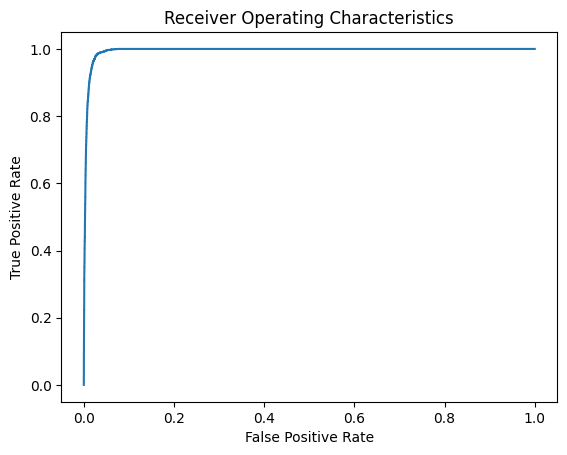

In [20]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()